## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

23.432124362388429

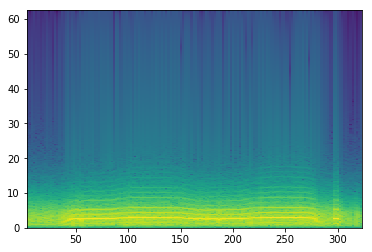

In [2]:
import glob

import numpy as np
import scipy as sp
import scipy.io
from scipy.signal import filtfilt, butter
import matplotlib.pyplot as plt

fs = 125


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, fs=125):
    """Bandpass filter the signal between 0.667 Hz and 4 Hz."""
    b, a = butter(3, (2 / 3, 4), btype='bandpass', fs=fs)
    return filtfilt(b, a, signal)
    
def RunPulseRateAlgorithm(data_fl, ref_fl):
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ref_bpm  = sp.io.loadmat(ref_fl)['BPM0']
    
    # Caculates magnitude of accelerometer
    acc_mag = np.sqrt(np.sum(np.square(np.vstack((accx, accy, accz))), axis = 0)) 
    
    # Bandpass signal between 40-240BPM.
    filt_ppg = BandpassFilter(ppg)
    filt_accmag = BandpassFilter(acc_mag)
    
    # Calculates spectrogram of the filtered signal.
    # The dataset gives the BPM value in every 8-second time window and two successive time windows overlap by 6 seconds.
    ppg_spec, ppg_freqs, _, _ = plt.specgram(filt_ppg, Fs = fs, NFFT=8 * fs, noverlap=6 * fs)
    accmag_spec, accmag_freqs, _, _ = plt.specgram(filt_accmag, Fs = fs, NFFT=8 * fs, noverlap=6 * fs)
    
    errors, confidence = [], []
    est_bpm = 0
    for i in range(accmag_spec.shape[1]):
        win_accmag = accmag_spec[:, i]
        win_ppg = ppg_spec[:, i]
        
        # Finds out dominant frequency for PPG and Accelerometer Magnitude signal.
        dominant_accmag_freq = accmag_freqs[np.argmax(win_accmag)]
        dominant_ppg_freq = ppg_freqs[np.argmax(win_ppg)]
        
        # If both the dominant frequencies don't match, then take this as the estimated pulse rate from this window.
        if(dominant_accmag_freq != dominant_ppg_freq):
            est_bpm = dominant_ppg_freq * 60
            
        # If both of them match, then further check the next strongest PPG frequencies if there is another good candidate.
        else:
            
            # Finds top 3 next dominant PPG and Accelerometer Magnitude frequencies.
            k = 3
            top_k_dominant_accmag_freqs = accmag_freqs[win_accmag.argsort()[-k:-1][::-1]]
            top_k_dominant_ppg_freqs = ppg_freqs[win_ppg.argsort()[-k:-1][::-1]]
            idx = 0
            
            # Now loop till (k - 1) and check if frequencies match or not.
            while(idx != (k - 1)):
                
                # If both the dominant frequencies don't match, then take this as the estimated pulse rate from this window.
                if(top_k_dominant_accmag_freqs[idx] != top_k_dominant_ppg_freqs[idx]):
                    est_bpm = top_k_dominant_ppg_freqs[idx] * 60
                    break
                idx += 1
    
        # Computes pulse rate estimates and estimation confidence.
        true_bpm = ref_bpm[i].item()
        error = np.abs(true_bpm - est_bpm)
        errors.append(error)
        
        window_f = 40 / 60
        est_frequency_window = (ppg_freqs > (est_bpm / 60) - window_f) & (ppg_freqs < (est_bpm / 60) + window_f)
        
        # Confidence is estimated by summing the frequency spectrum near the pulse rate estimate and dividing it by the sum of the entire spectrum.
        ppg_power = np.sum(win_ppg[est_frequency_window])
        total_power = np.sum(win_ppg)
        confidence.append(ppg_power / total_power)
        
    # Returns per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return np.array(errors), np.array(confidence)
Evaluate()

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - The Evaluate function will load the dataset, calculate pulse rate using RunPulseRateAlgorithm function and finally give confidence interval for each given heart rate.

> - **Data Description** -
1. The data contains two-channel PPG signals, three-axis acceleration signals, and one-channel ECG signals from subjects with age >from 18 to 35.
2. The data is sampled at 125Hz from 12 different subjects
3. The data provides ground-truth heart rate (in BPM) in every 8-second time window with overlap of 6 seconds with two successive time windows .


> - **Algorithhm Description** 
1. The algorithm works as follows:
  1. Perform bandpass filter on PPG and Accelerometer Magnitude signal.
  2. Use plt.specgram function to get FFT and freqs in a window of 8 seconds with an overlap of 6 seconds.
  3. Now calculate estimate pulse rate by iterating in each window
    1. Find dominant frequencies from PPG and accelerometer magnitude signal.
    2. If both the dominant frequencies don't match, then take this as the estimated pulse rate from this window.
    3. If both of them match, then further check the next strongest PPG frequencies if there is another good candidate.
  4. Now calculate the MAE between reference pulse rate and estimated pulse rate.
  5. Confidence is estimated by summing the frequency spectrum near the pulse rate estimate and dividing it by the sum of the entire spectrum.
  6. The algorithm generates pulse rate estimates and confidence every 2s.
2. The specific aspects of the physiology that it takes advantage of:
  1. We use PPG signals for measuring heart rate.
  1. The capillaries in the wrist are filled with blood when the ventricles contract.
  1. When there are few red blood cells in these capillaries, the light from the PPG sensor will be reflected in a large amount.
  1. When the blood cells are many, they absorb the light, so the optical detector will detect less light.
  1. Changes in the light detected by the optical detector, will produce an oscillating waveform which is the pulse rate.
3. Now calculate the MAE between reference pulse rate and estimated pulse rate.
4. Confidence is estimated by summing the frequency spectrum near the pulse rate estimate and dividing it by the sum of the entire spectrum.
5. The algorithm generates pulse rate estimates and confidence every 2s.
6. The specific aspects of the physiology that it takes advantage of:
  1. We use PPG signals for measuring heart rate.
  2. The capillaries in the wrist are filled with blood when the ventricles contract.
  3. When there are few red blood cells in these capillaries, the light from the PPG sensor will be reflected in a large amount.
  4. When the blood cells are many, they absorb the light, so the optical detector will detect less light.
  5. Changes in the light detected by the optical detector, will produce an oscillating waveform which is the pulse rate.
7. A description of the algorithm outputs: The algorithm calculates estimated pulse rate (in BPM) along with confidence estimates. A higher confidence value means that this estimate should be more accurate than an estimate with a lower confidence value.
8. Caveats on algorithm outputs: The algorithm can be affected by noise through other sources.
9. Common failure modes: The algorithm may be affected by arm and finger motion.

> - **Algorithm Performance** 
1. The performance is calculated using MAE between reference pulse rate and estimated pulse rate.
2. The other metrics such as Precision, Recall and F1-score can also be computed.
3. The MAE obtained on the test data is 12.5.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 